# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [15]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns



from global_constants import L, R, MU, LBD, N1, N2

from new_plate_elliptic_hole import Plate 

# Elliptical axis in x direction
Rx = 0.14
Ry = R**2 / Rx
# Edge samples
N = 50 #40
# Number of collocation points
M = 500 #500

# Epochs
epochs = 25432#5000
# Batch size
batch_size = 250 #64
# Learning rate
lr = 0.001 #0.001
# Scheduler step width
scheduler_step = 1000
# Gamma factor of scheduler
scheduler_gamma = 0.8
expo_gamma = 0.999
# Weight update factor
ALPHA = 0.9
# Number of hidden neurons
HN = 50 #256 #recommended by wang et al
# Number of hidden layers
LAYERS = 4
# Variance
SIGMA = 1.0
# Fourier features
FEATURES = 50 #40
# precision
#torch.set_default_dtype(torch.float32)
DTYPE = torch.float32



#step width for updating weights
step_size = 100
#HNEU_split*epochs ->moment for splitting total_NEU to NEU and HNEU 
HNEU_split = 0.0



def generate_radii_list(min_Ra_x, max_Ra_x, step):
    if step == 0:
        rad_x_list = [min_Ra_x, max_Ra_x]
    else:
        num_steps = int((max_Ra_x - min_Ra_x) / step) + 1
        rad_x_list = np.linspace(min_Ra_x, max_Ra_x, num_steps)
        rad_x_list = [round(rad_x, 2) for rad_x in rad_x_list]
    rad_y_list = []
    for rad_x in rad_x_list:
        rad_y_list.append(R**2 / rad_x)
    return rad_x_list, rad_y_list

def generate_multiple_plates(min_Ra_x, max_Ra_x, step_size):

    list_collo = torch.empty(0,3,requires_grad=True)
    list_top = torch.empty(0,3,requires_grad=True)
    list_right = torch.empty(0,3,requires_grad=True)
    list_left = torch.empty(0,3,requires_grad=True)
    list_bottom = torch.empty(0,3,requires_grad=True)
    list_hole = torch.empty(0,5,requires_grad=True)

    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, step_size)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        collo_points, top_points, right_points, left_points, bottom_points, hole_points = p1.generate_dataset()
        list_collo = torch.cat((list_collo, collo_points), dim=0)
        list_top = torch.cat((list_top, top_points), dim=0)
        list_right = torch.cat((list_right, right_points), dim=0)
        list_left = torch.cat((list_left, left_points), dim=0)
        list_bottom = torch.cat((list_bottom, bottom_points), dim=0)
        list_hole = torch.cat((list_hole, hole_points), dim=0)
        
    return list_collo, list_top, list_right, list_left, list_bottom, list_hole 

def generate_multiple_plates_dict(min_Ra_x, max_Ra_x):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("x_right", 2, 0),
            ("y_right", 2, 1),
            ("x_left", 3, 0),
            ("y_left", 3, 1),
            ("x_bottom", 4, 0),
            ("y_bottom", 4, 1),
            ("x_hole", 5, 0),
            ("y_hole", 5, 1),   
        ] 
    
    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, 0.01)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        data_one_plate = p1.generate_dataset()

        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][:,tuple[2]])
        #plotting one plate
        #p1.plot_plate_with_hole(*data_one_plate)
    for key in dict_plate_points: 
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        print(key, "besteht aus",dict_plate_points[key].size(), "Datenpunkten")

    collo_points = torch.column_stack([dict_plate_points["x_collo"], dict_plate_points["y_collo"]])
    top_points = torch.column_stack([dict_plate_points["x_top"], dict_plate_points["y_top"]])
    right_points = torch.column_stack([dict_plate_points["x_right"], dict_plate_points["y_right"]])
    left_points = torch.column_stack([dict_plate_points["x_left"], dict_plate_points["y_left"]])
    bottom_points = torch.column_stack([dict_plate_points["x_bottom"], dict_plate_points["y_bottom"]])
    hole_points = torch.column_stack([dict_plate_points["x_hole"], dict_plate_points["y_hole"]])

    return collo_points, top_points, right_points, left_points, bottom_points, hole_points



p98 = Plate(0.10, N, M)
collocation, top, right, left, bottom, hole = p98.generate_dataset()
p98.plot_plate_with_hole(collocation, top, right, left, bottom, hole)

p99 = Plate(0.18, N, M)
collocation, top, right, left, bottom, hole = p99.generate_dataset()
p99.plot_plate_with_hole(collocation, top, right, left, bottom, hole)


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [16]:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input layer
        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(2 * FEATURES, HN).type(DTYPE)]
        )
        # Hidden layers
        for _ in range(LAYERS - 1):
            self.layers.append(torch.nn.Linear(HN, HN).type(DTYPE))
        # Output layer
        self.output_layer = torch.nn.Linear(HN, 2).type(DTYPE)

        # Initialize weights with Glorot scheme
        for layer in self.layers:
            torch.nn.init.xavier_uniform_(layer.weight, gain= torch.nn.init.calculate_gain('tanh'))

        # Sample B from normal distribution
        self.B = torch.normal(0.0, SIGMA, size=(3, FEATURES), dtype=DTYPE)

    def forward(self, x):
        # Random Fourier feature embedding
        x = torch.cat(
            [torch.sin(2 * np.pi * x @ self.B), torch.cos(2 * np.pi * x @ self.B)],
            dim=-1,
        )
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)


## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [17]:
def epsilon(xyr):
    # Compute deformation gradient
    #inputs = torch.column_stack([x,y])
    dudx = torch.func.jacrev(net)(xyr)
    # print(np.shape(xx))
    # print(xx)
    return 0.5 * (dudx[:,:-1] + dudx[:,:-1].T)

def sigma(xyr):
    # Compute (small deformation) strain
    eps = epsilon(xyr)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2)


def pde_residual(xyr):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(xyr)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [18]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo, top, right, left, bottom, hole):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    pred_stress_left = torch.vmap(sigma)(left)
    pred_s_left_xy = pred_stress_left[:, 0, 1]
    s_left_xy = torch.zeros_like(pred_s_left_xy)
    left_symm_error = mse(pred_s_left_xy, s_left_xy)

    pred_stress_bottom = torch.vmap(sigma)(bottom)
    pred_s_bottom_xy = pred_stress_bottom[:, 0, 1]
    s_bottom_xy = torch.zeros_like(pred_s_bottom_xy)
    bottom_symm_error = mse(pred_s_bottom_xy, s_bottom_xy)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole[:,:3])
    n_hole = hole[:,-2:]
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (
        left_error,
        left_symm_error,
        right_error,
        bottom_error,
        bottom_symm_error,
        top_error,
        hole_error,
        pde_error,
    )

In [19]:
def compare_hole_stress(comp_rad_x):

    #generate input and output hole points for reference
    p_comp = Plate(comp_rad_x, N, M) 
    data_input_comp, data_output_comp, data_hole_comp = p_comp.load_reference_data()
    comp_collo, comp_top, comp_right, comp_left, comp_bottom, comp_hole = p_comp.generate_dataset()
    data_hole_comp = data_hole_comp.numpy()
    data_hole_comp = data_hole_comp[data_hole_comp[:, 0].argsort()]

    #interpolate data_stress_x1 and data_stress_y1
    f_stress_x = interp1d(data_hole_comp[:, 0], data_hole_comp[:, 2], kind='cubic')
    f_stress_y = interp1d(data_hole_comp[:, 0], data_hole_comp[:, 3], kind='cubic')
    x_new = np.linspace(data_hole_comp[:, 0][-1], data_hole_comp[:, 0][0], comp_hole[:, 0].size(dim=0))
    y_stress_x = f_stress_x(x_new)
    y_stress_y = f_stress_y(x_new)

    # compare computed stressError(PINN) with actual stressError
    stress_hole_PINN = torch.vmap(sigma)(comp_hole[:, :-2])
    calc_stressError = mse(stress_hole_PINN[:, 0, 0], torch.tensor(y_stress_x)) + mse(stress_hole_PINN[:, 1, 1], torch.tensor(y_stress_y))

    plt.figure(figsize=(5, 3))
    plt.plot(comp_hole[:, 0], stress_hole_PINN[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
    plt.plot(data_hole_comp[:, 0], data_hole_comp[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
    plt.plot(comp_hole[:, 0], stress_hole_PINN[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
    plt.plot(data_hole_comp[:, 0], data_hole_comp[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
    plt.xlabel("x")
    plt.ylabel("Stress")
    plt.show()

    return calc_stressError


## Training 

In [20]:
def compute_gradient_norm(loss):
    weight_params = [param for name, param in net.named_parameters() if 'weight' in name]
    grads = torch.autograd.grad(loss, weight_params)
    return sum(torch.linalg.norm(grad) for grad in grads)

def update_weight(weight, grad_sum, norm):
    new_weight = grad_sum / norm
    return ALPHA * weight + (1 - ALPHA) * new_weight

Starting with Adam optimizer...


  4%|▍         | 999/25432 [03:04<1:10:02,  5.81it/s]

total_loss: 6767.75537109375, hole_loss:  0.10280957818031311, neumann_loss:  0.4223872721195221, pde_loss: 6600.7744140625, dirichlet_loss: 4.043307058054779e-07


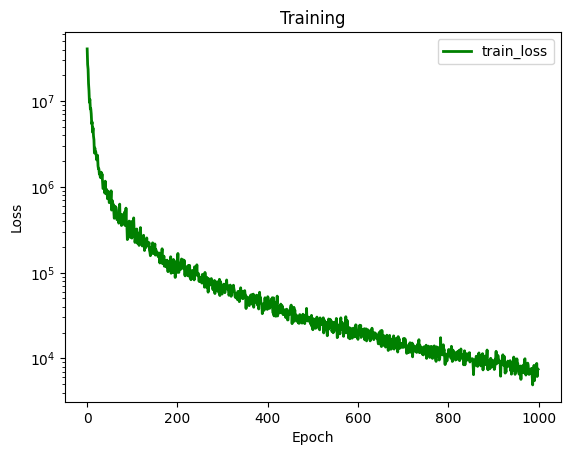

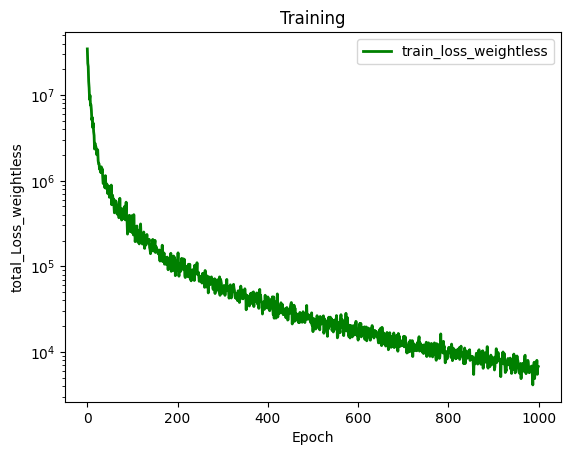

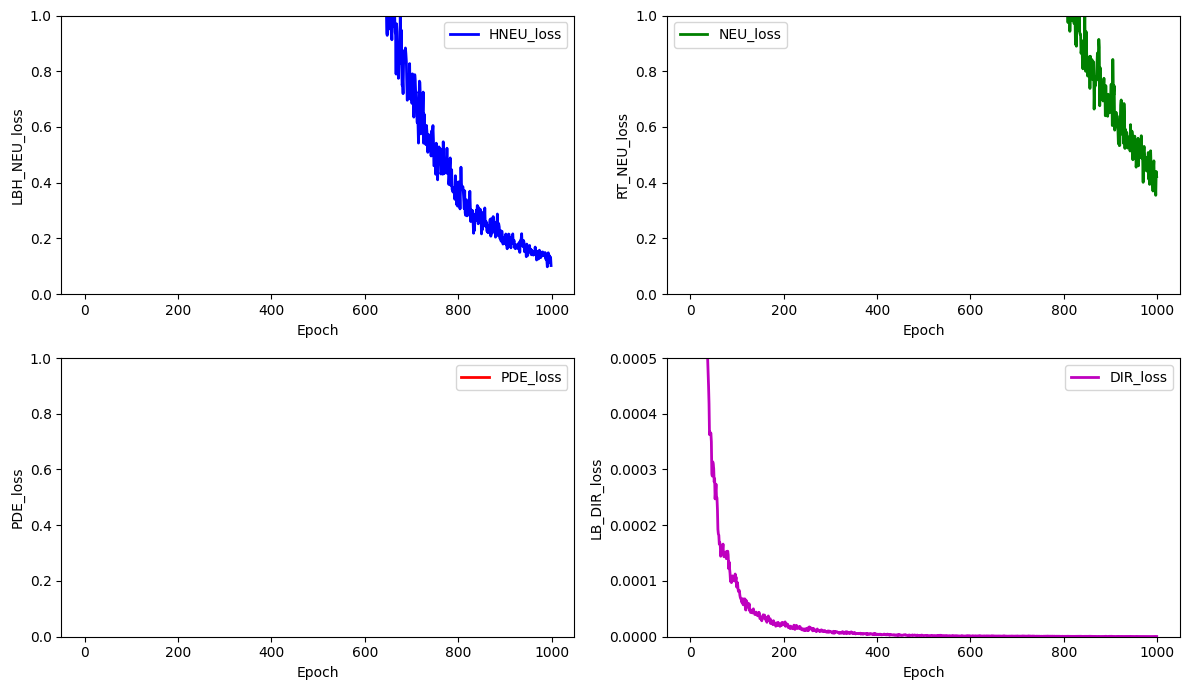

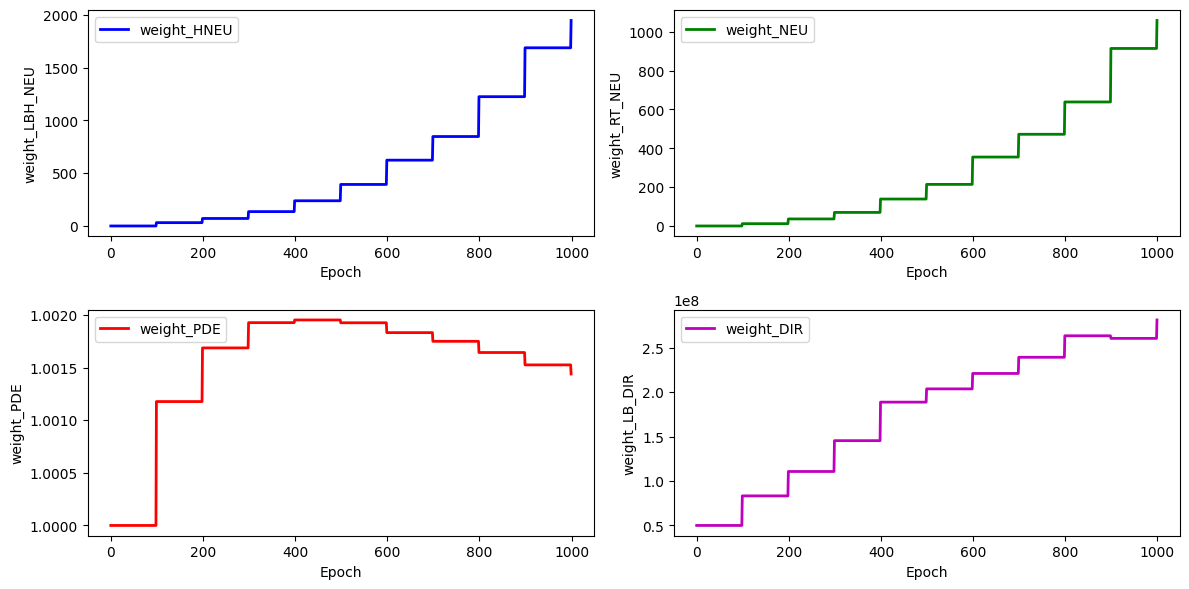

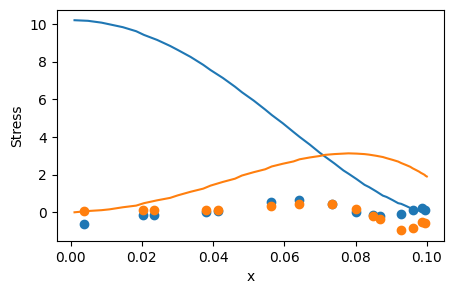

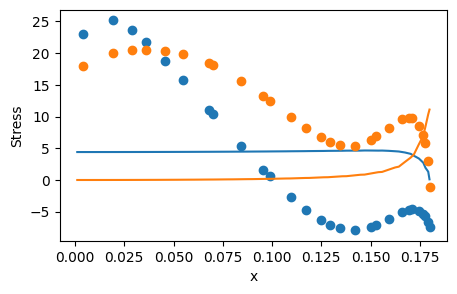

  8%|▊         | 1999/25432 [06:29<1:12:25,  5.39it/s]

total_loss: 1556.49951171875, hole_loss:  0.015952639281749725, neumann_loss:  0.03193563222885132, pde_loss: 1526.6376953125, dirichlet_loss: 1.1236072339215752e-07


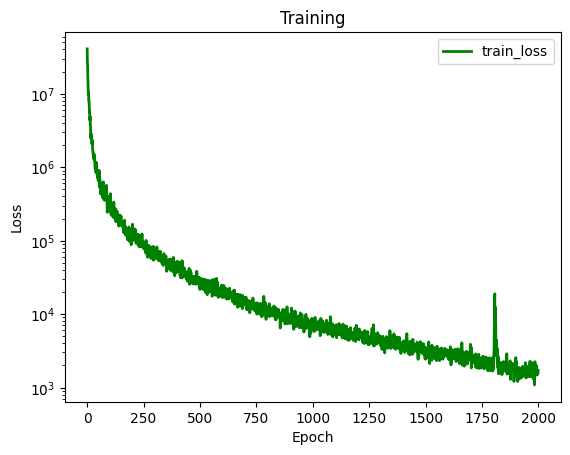

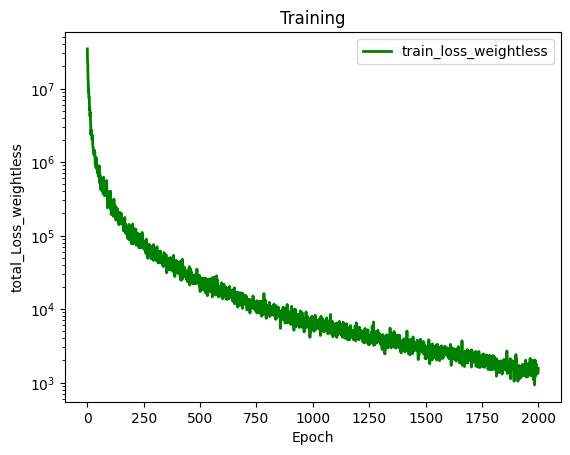

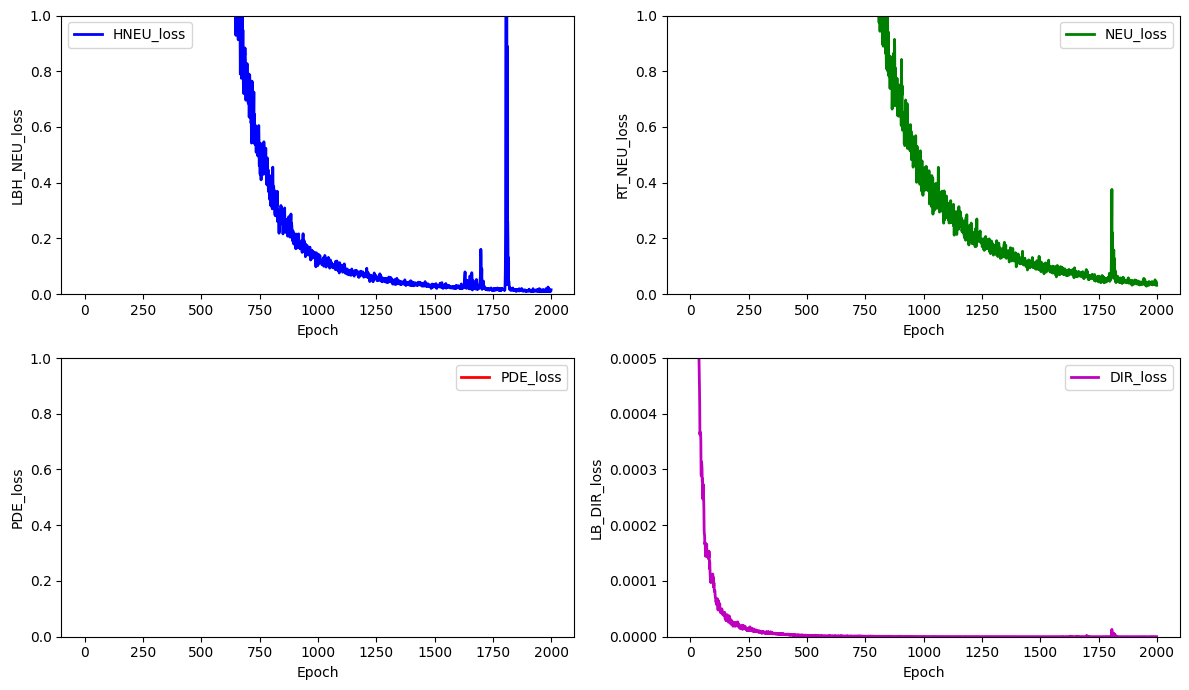

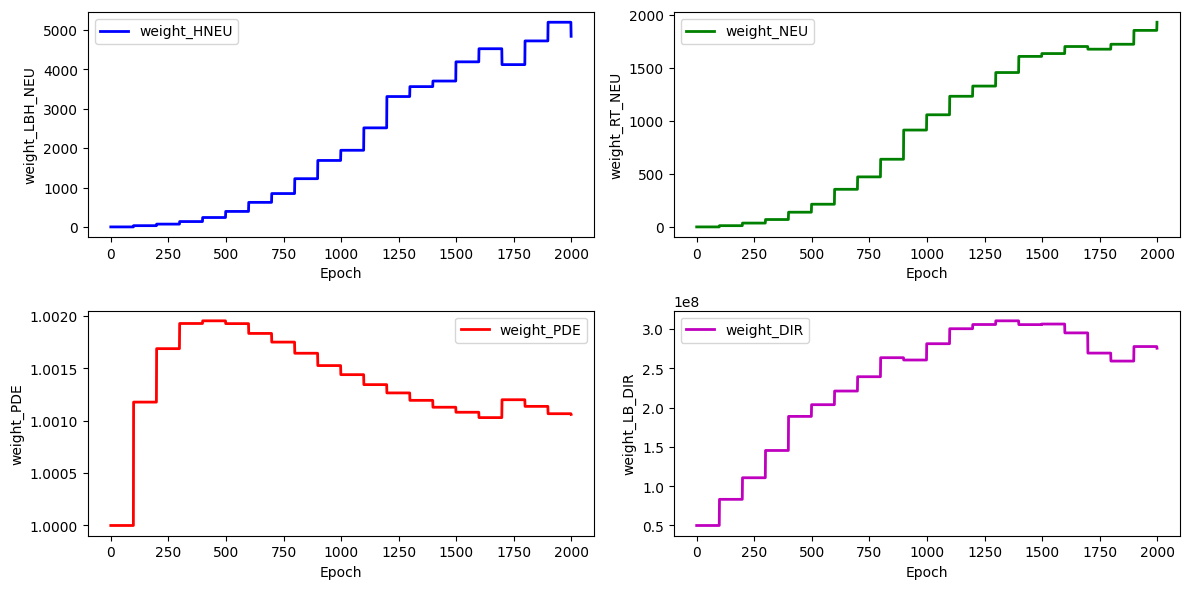

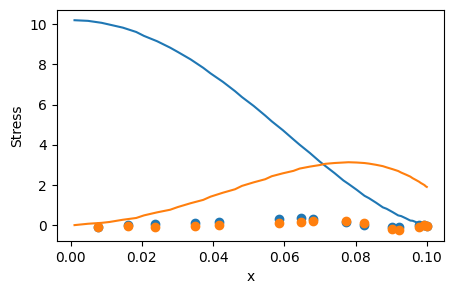

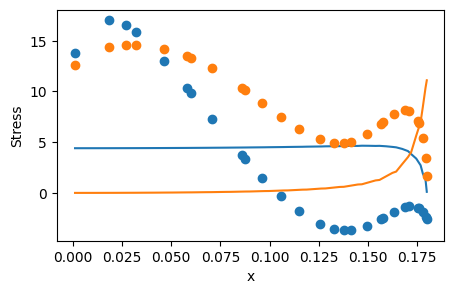

 10%|▉         | 2447/25432 [08:02<1:15:33,  5.07it/s]


KeyboardInterrupt: 

In [21]:

#scheduler = ExponentialLR(optimizer, gamma=0.999)
loss_history = []
HNEU_loss_history = []
PDE_loss_history = []
NEU_loss_history = []
DIR_loss_history = []
loss_weightless_history = []
weightHNEU_history = []
weightNEU_history = []
weightPDE_history = []
weightDIR_history = []


# Weight of PDE lossWeight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06
# Weight of Neumann loss explicitly for the right and top boundary condition
W_NEU = 6.4531255763296895e-06 #previous value -> 1.88e-06
# Weight of Neumann loss explicitly for the hole boundary condition
W_HNEU = 8.2e-05
W_PDE = 8.376708219353885e-06 #previous value -> 3.14e-06
# Weight of data losses
W_DIR = 1.0
W_STRESS = 0.0 #previous value -> 1.0e-07 
W_DISP = 0.0


target_loss = torch.tensor(5)

# #Weight_NEU and Weight_PDE 
# Weight_RT_NEU = torch.tensor(W_NEU, requires_grad=True) #previous value -> 6.4531255763296895e-06
# Weight_LBH_NEU = torch.tensor(W_HNEU, requires_grad=True)
# Weight_PDE = torch.tensor(W_PDE, requires_grad=True) #previous value -> 8.376708219353885e-06
# Weight_LB_DIR = torch.tensor(W_DIR, requires_grad=True)
# Weight_STRESS = torch.tensor(W_STRESS, requires_grad=True)

#set all weights to 1 
Weight_RT_NEU = torch.tensor(1.0, requires_grad=True) #previous value -> 2.5
Weight_LBH_NEU = torch.tensor(1.0, requires_grad=True) #previous value -> 2.25
Weight_PDE = torch.tensor(1.0, requires_grad=True) #previous value -> 1.6
Weight_LB_DIR = torch.tensor(5e+07, requires_grad=True)
Weight_STRESS = torch.tensor(1.0, requires_grad=True)


def training(comp_rad_x, target_loss):

    #reset all net parameters 
    #net.apply(weight_reset)

    #generate input and output data for reference solutions
    p_comp = Plate(comp_rad_x, N, M) 
    data_input_comp, data_output_comp, data_hole_comp = p_comp.load_reference_data()

    #hyperparameter weights
    weights = [Weight_LBH_NEU, Weight_RT_NEU, Weight_PDE, Weight_LB_DIR]
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    #scheduler = ExponentialLR(optimizer,  gamma= expo_gamma)
    print("Starting with Adam optimizer...")
    for epoch in tqdm(range(epochs)):

        collocation, top, right, left, bottom, hole = generate_multiple_plates(0.10, 0.18, 0.8)

        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            optimizer.zero_grad()

            # Compute physics losses
            (
                left_l,
                left_sl,
                right_l,
                bottom_l,
                bottom_sl,
                top_l,
                hole_l,
                pde_l,
            ) = compute_physics_losses(collo, top, right, left, bottom, hole)

            if W_DISP < 1E-10 and W_STRESS < 1E-10:
                # No data losses needed (we can accelerate training by skipping this part)
                stress_l = 0.0
                disp_l = 0.0
            else:
                # Get samples from reference solution
                samples = torch.randperm(data_output_comp.size()[0])[::100]
                # Reference solutions
                s_data = data_output_comp[samples, 0:3]
                e_data = data_output_comp[samples, 4:7]
                u_data = data_output_comp[samples, 7:10]
                # Predictions
                s_pred = torch.vmap(sigma)(data_input_comp[samples, 0:3])
                e_pred = torch.vmap(epsilon)(data_input_comp[samples, 0:3])
                u_pred = net(data_input_comp[samples, 0:3])
                # Compute data losses
                ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
                ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
                ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
                stress_l = ds_xx + ds_yy + ds_xy
                du_x = mse(u_data[:, 0], u_pred[:, 0])
                du_y = mse(u_data[:, 1], u_pred[:, 1])
                disp_l = du_x + du_y

            # Aggregate losses
            lbh_neumann_losses_nd = left_sl + bottom_sl + hole_l
            rt_neumann_losses_nd = right_l + top_l
            total_neumann_loss_nd = right_l + top_l + left_sl + bottom_sl + hole_l
            pde_losses_nd = pde_l 
            lb_dirichlet_losses_nd = left_l + bottom_l

            loss = (
                    weights[0] * lbh_neumann_losses_nd #Weight_HNEU 
                    + weights[1] * rt_neumann_losses_nd  #Weight_NEU
                    + weights[2] * pde_losses_nd #Weight_PDE 
                    + weights[3] * lb_dirichlet_losses_nd #Weight_DIR
                    )
            
            loss_weightless = (
                lbh_neumann_losses_nd
                + rt_neumann_losses_nd 
                + pde_losses_nd 
                + lb_dirichlet_losses_nd 
            )
            

            # Make optimization step after batch
            loss.backward(retain_graph=True)
            optimizer.step()
            
            
        #update non dimensionalizated weights 
        if (epoch+1) % step_size == 0:

            # Compute physics losses
            (
                left_l,
                left_sl,
                right_l,
                bottom_l,
                bottom_sl,
                top_l,
                hole_l,
                pde_l,
            ) = compute_physics_losses(collo, top, right, left, bottom, hole)

            # Aggregate losses
            lbh_neumann_losses_nd = left_sl + bottom_sl + hole_l
            rt_neumann_losses_nd = right_l + top_l
            total_neumann_loss_nd = right_l + top_l + left_sl + bottom_sl + hole_l
            pde_losses_nd = pde_l 
            lb_dirichlet_losses_nd = left_l + bottom_l

            # Compute L2 norm for each gradient
            norm_grad_LBH_neumann_losses_nd = compute_gradient_norm(lbh_neumann_losses_nd)
            norm_grad_RT_neumann_losses_nd = compute_gradient_norm(rt_neumann_losses_nd)
            norm_grad_pde_losses_nd = compute_gradient_norm(pde_losses_nd)
            norm_grad_LB_dirichlet_losses_nd = compute_gradient_norm(lb_dirichlet_losses_nd)

            # Compute sum of all gradients for each loss
            weight_grad_sum = (
                norm_grad_LBH_neumann_losses_nd
                + norm_grad_RT_neumann_losses_nd
                + norm_grad_pde_losses_nd
                + norm_grad_LB_dirichlet_losses_nd
            )

            #print(f"adopting weights after {step_size} epochs")
            new_weights = [Weight_LBH_NEU, Weight_RT_NEU, Weight_PDE, Weight_LB_DIR]
            norm_grad_losses_nd = [norm_grad_LBH_neumann_losses_nd, norm_grad_RT_neumann_losses_nd,
                                    norm_grad_pde_losses_nd, norm_grad_LB_dirichlet_losses_nd]

            for index, weight in enumerate(weights):

                new_weights[index] = weight_grad_sum/ norm_grad_losses_nd[index]

            #update new weights
            for index, weight in enumerate(weights):
                new_weight = 0.9*weight + 0.1*new_weights[index]
                weights[index] = new_weight.clone().detach().requires_grad_(True)
                #print(f"for weight {index} new weight_value: {weights[index]}")

        # Make scheduler step after full epoch
        scheduler.step()  

  
        
        # append loss to history (=for plotting)
        with torch.autograd.no_grad():
            loss_history.append(float(loss.data))
            loss_weightless_history.append(float(loss_weightless.data))
            HNEU_loss_history.append(float(lbh_neumann_losses_nd))
            NEU_loss_history.append(float(rt_neumann_losses_nd))
            PDE_loss_history.append(float(pde_losses_nd))
            DIR_loss_history.append(float(lb_dirichlet_losses_nd))
            weightHNEU_history.append(float(weights[0]))
            weightNEU_history.append(float(weights[1]))
            weightPDE_history.append(float(weights[2]))
            weightDIR_history.append(float(weights[3]))
            

        #print progress during training
        if (epoch+1) % (step_size*10) == 0:
            print(f"total_loss: {loss_weightless.data}, hole_loss:  {lbh_neumann_losses_nd}, neumann_loss:  {rt_neumann_losses_nd}, pde_loss: {pde_losses_nd}, dirichlet_loss: {lb_dirichlet_losses_nd}")
            
            with torch.autograd.no_grad():
                plt.plot(loss_history, c='g', label='train_loss', linewidth=2.0)
                plt.yscale("log")
                plt.title("Training")
                plt.ylabel("Loss")
                plt.xlabel("Epoch")
                plt.legend()
                plt.show()

                plt.plot(loss_weightless_history, c='g', label='train_loss_weightless', linewidth=2.0)
                plt.yscale("log")
                plt.title("Training")
                plt.ylabel("total_Loss_weightless")
                plt.xlabel("Epoch")
                plt.legend()
                plt.show()

                fig, axs = plt.subplots(2, 2, figsize=(12, 7))

                # plot for HNEU_loss_history
                axs[0, 0].plot(HNEU_loss_history, c='b', label='HNEU_loss', linewidth=2.0)
                axs[0, 0].set_ylabel("LBH_NEU_loss")
                axs[0, 0].set_xlabel("Epoch")
                axs[0, 0].legend()
                axs[0, 0].set_yscale('log')
                axs[0, 0].set_ylim([1e-6, 10.0])  

                # plot for NEU_loss_history
                axs[0, 1].plot(NEU_loss_history, c='g', label='NEU_loss', linewidth=2.0)
                axs[0, 1].set_ylabel("RT_NEU_loss")
                axs[0, 1].set_xlabel("Epoch")
                axs[0, 1].legend()
                axs[0, 1].set_yscale('log')
                axs[0, 1].set_ylim([1e-6, 10.0])  

                # plot for PDE_loss_history
                axs[1, 0].plot(PDE_loss_history, c='r', label='PDE_loss', linewidth=2.0)
                axs[1, 0].set_ylabel("PDE_loss")
                axs[1, 0].set_xlabel("Epoch")
                axs[1, 0].legend()
                axs[1, 0].set_yscale('log')
                axs[1, 0].set_ylim([1e-4, 1000.0])  

                # plot for DIR_loss_history
                axs[1, 1].plot(DIR_loss_history, c='m', label='DIR_loss', linewidth=2.0)
                axs[1, 1].set_ylabel("LB_DIR_loss")
                axs[1, 1].set_xlabel("Epoch")
                axs[1, 1].legend()
                axs[1, 1].set_yscale('log')
                axs[1, 1].set_ylim([1e-11, 1e-5]) 

                plt.tight_layout()
                plt.show()




                fig, axs = plt.subplots(2, 2, figsize=(12, 6))

                # plot for weightHNEU_history
                axs[0, 0].plot(weightHNEU_history, c='b', label='weight_HNEU', linewidth=2.0)
                axs[0, 0].set_ylabel("weight_LBH_NEU")
                axs[0, 0].set_xlabel("Epoch")
                axs[0, 0].legend()

                # plot for weightNEU_history
                axs[0, 1].plot(weightNEU_history, c='g', label='weight_NEU', linewidth=2.0)
                axs[0, 1].set_ylabel("weight_RT_NEU")
                axs[0, 1].set_xlabel("Epoch")
                axs[0, 1].legend()

                #plot for weightPDE_history
                axs[1, 0].plot(weightPDE_history, c='r', label='weight_PDE', linewidth=2.0)
                axs[1, 0].set_ylabel("weight_PDE")
                axs[1, 0].set_xlabel("Epoch")
                axs[1, 0].legend()

                # plot for weightDIR_history
                axs[1, 1].plot(weightDIR_history, c='m', label='weight_DIR', linewidth=2.0)
                axs[1, 1].set_ylabel("weight_LB_DIR")
                axs[1, 1].set_xlabel("Epoch")
                axs[1, 1].legend()

                plt.tight_layout()
                plt.show()

                # compare computed stressError(PINN) with actual stressError
                stress_error_010 = compare_hole_stress(0.10)
                stress_error_010 = compare_hole_stress(0.18)

    print(f"total_loss: {loss_weightless.data}, hole_loss:  {lbh_neumann_losses_nd}, neumann_loss:  {rt_neumann_losses_nd}, pde_loss: {pde_losses_nd}, dirichlet_loss: {lb_dirichlet_losses_nd}")

    # compare computed stressError(PINN) with actual stressError


    lowest_loss = target_loss
    if(loss.data < target_loss):
        print(f"previous lowest lost  {target_loss}")
        lowest_loss = loss.data
        print(f"lowest loss {lowest_loss} archived, PINN is saved: 'net_param/net_{lowest_loss:.8f}.pth")
        torch.save(net.state_dict(), f'net_param/net_{lowest_loss:.8f}.pth')
    return stress_error_010, lowest_loss


# weights_optimizer = torch.optim.Adam([Weight_NEU, Weight_PDE], lr=1)
# weights_scheduler = ExponentialLR(weights_optimizer, gamma=1)
net = Net()
for i in range(1):
#weights_optimizer.zero_grad()
    mse_error, lowest_loss = training(0.14, target_loss)
    target_loss = lowest_loss

    #mse_error.backward()
    #weights_optimizer.step()
    #weights_scheduler.step()

    #save net parameters
    #torch.save(net.state_dict(), f'net_param/net_{rad_x:.2f}.pth')


    with torch.autograd.no_grad():
        stress_error_hole = compare_hole_stress(0.14)
        print("final stress_error at hole is ", stress_error_hole)

        plt.plot(loss_history, c='g', label='train', linewidth=2.0)
        plt.yscale("log")
        plt.title("Training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()
    
    # print weights and stress error and modify weight values for the next iteration
    print(f"Weight_HNEU: {Weight_LBH_NEU.item()}, Weight_NEU: {Weight_RT_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Weight_STRESS: {Weight_STRESS.item()}, Stress Error: {mse_error.item()}") 
    #Weight_STRESS = Weight_STRESS *1/1.1
    # Weight_NEU = Weight_NEU * (1.1/1.0)
    # Weight_PDE = Weight_PDE * (1.1/1.0)
    # Weight_HNEU = Weight_HNEU * (1.1/1.0)

#plt.figure(figsize=(8, 4))
plt.plot(loss_history, c='g', label='train_loss', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(loss_weightless_history, c='g', label='train_loss_weightless', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss_weightless")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(PDE_loss_history, c='g', label='pde_loss', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("pde_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(weightPDE_history, c='g', label='weight_PDE', linewidth=2.0)
plt.title("Training")
plt.ylabel("weight_PDE")
plt.xlabel("Epoch")
plt.legend()
plt.show()




## Visualization of results

In [ ]:
val_rad_x = 0.14
val_plate = Plate(val_rad_x, N, M) 
data_input1, data_output1, data_hole1 = val_plate.load_reference_data()
val_collo, val_top, val_right, val_left, val_bottom, val_hole = val_plate.generate_dataset()

stress_hole1 = torch.vmap(sigma)(val_hole[:,:-2])
data_hole1 = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole1 = data_hole1[data_hole1[:, 0].argsort()]

with torch.no_grad():
    fig = go.Figure()
    m1 = dict(color="blue")
    m2 = dict(color="orange")
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole1[:, 0, 0],
            marker=m1,
            mode="markers",
            name="σ_xx (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole1[:, 0],
            y=data_hole1[:, 2],
            marker=m1,
            mode="lines",
            name="σ_xx (FEM)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole1[:, 1, 1],
            marker=m2,
            mode="markers",
            name="σ_yy (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole1[:, 0],
            y=data_hole1[:, 3],
            marker=m2,
            mode="lines",
            name="σ_yy (FEM)",
        )
    )
    fig.update_layout(
        template="none", width=600, height=400, title="Stress at hole", showlegend=True
    )
    fig.show()

In [ ]:

val_rad_x = 0.14
p_val = Plate(val_rad_x, N, M) 
val_data_input, val_data_output, val_data_hole = p_val.load_reference_data()
val_collo, val_top, val_right, val_left, val_bottom, val_hole = p_val.generate_dataset()

# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = Rx * np.ones(np.shape(val_x))
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True, dtype=DTYPE)


# Compute model predictions on the validation domain
disp = net(val)
def_val = val[:, :-1] + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = val_data_output[:, 0:3]
s_pred = torch.vmap(sigma)(val_data_input[:, 0:3])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*val_data_input[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*val_data_input[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*val_data_input[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)

